# Обработка и генерация изображений
## Лекция №6. Метрики оценки моделей

### 1. Постановка задачи генерации

*****

<b>Дано:</b>
- Набор независимых одинаково распределенных случайных величин $\{X_i\}_{i=1}^{n} \in \mathcal{X}$  (напр, $\mathcal{X} \in \mathcal{R}^m$) из неизвестного распределения $\pi(x)$.\
- Выборка $\{x_i\}_{i=1}^{n}$, где $x_i$ - реализация случайной величины.

<b>Задача:</b> 
1. Оценить $\pi(x)$ по выборке
2. Генерировать новые элементы $x$ из $\pi(x)$

### 2. Генеративные модели

*****

<div style="text-align: center;">
    <img src=./imgs/generative_models_zoo.png style=width:800px>
    <img src=./imgs/generative_models.png style=width:800px>
</div>

[Исаченко Р. Порождающие модели машинного обучения. МФТИ, 2023. Youtube](https://www.youtube.com/playlist?list=PLk4h7dmY2eYHVCEMMMqdKes__ehs5mRtR)

In [1]:
# подключение библиотек
import os

import numpy as np
import torch
from PIL import Image 
import torchvision.transforms as transforms


# чтение сгенерированных и реальных изображений и преобразование в тензоры
def read_pair_images(path_orig='./imgs/original', path_gen='./imgs/generated'):
    gen_file_paths = [path_gen + '/' + file_name for file_name in os.listdir(path_gen)]
    orig_file_paths = [path_orig + '/' + file_name for file_name in os.listdir(path_orig)]

    gen_tensors = torch.zeros((len(gen_file_paths), 3, 512, 512))
    orig_tensors = torch.zeros((len(orig_file_paths), 3, 512, 512))

    pil_transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.PILToTensor()
        ])

    for index, (orig_file_path, gen_file_path) in enumerate(zip(orig_file_paths, gen_file_paths)):
        gen_im = Image.open(gen_file_path)
        orig_im = Image.open(orig_file_path)
        gen_tensor = pil_transform(gen_im) / 256
        orig_tensor = pil_transform(orig_im) / 256

        gen_tensors[index] = gen_tensor
        orig_tensors[index] = orig_tensor
    
    return orig_tensors, gen_tensors


# чтение изображений и преобразование в тензор
def read_image(path='./imgs/augmented/origin.jpg'):
    pil_transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.PILToTensor()
        ])

    im = Image.open(path)
    im_tensor = pil_transform(im)
    im_tensor = np.transpose(im_tensor.numpy(), (1, 2, 0))
    return im_tensor

In [ ]:
from GPUtil import showUtilization as gpu_usage
import gc

# контроль памяти GPU
gc.collect()
torch.cuda.empty_cache()
gpu_usage()

##### Пример: Kandinsky2.2

<div style="text-align: center;">
    <img src=./imgs/kandinsky2.2.png style=width:800px>
</div>

In [5]:
path = './data/dataset'

captions = np.load(path + '/captions.npy', mmap_mode='r')
# images = np.load(path + '/images.npy', mmap_mode='r')

In [8]:
from diffusers import KandinskyV22Pipeline, KandinskyV22PriorPipeline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# преобразование промптов в эмбеддинги
pipe_prior = KandinskyV22PriorPipeline.from_pretrained("kandinsky-community/kandinsky-2-2-prior").to(device)

image_embs, negative_image_embs = pipe_prior(captions).to_tuple()
del pipe_prior

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# генерация изображений по эмбеддингам промптов
pipe = KandinskyV22Pipeline.from_pretrained("kandinsky-community/kandinsky-2-2-decoder").to(device)

for index, (image_emb, negative_image_emb) in enumerate(zip(image_embs, negative_image_embs)):
    image = pipe(
        image_embeds=image_emb.reshape(1, -1),
        negative_image_embeds=negative_image_emb.reshape(1, -1),
        height=512,
        width=512,
        num_inference_steps=50,
    ).images
    image[0].save(f"./imgs/generated/{index + 1}.png")

In [2]:
orig_tensors, gen_tensors = read_pair_images()

##### Пример: Аугментация

In [490]:
# чтение изображения
import numpy as np

im_tensor = read_image()

In [491]:
import imgaug as ia
import imgaug.augmenters as iaa

seed = 1

contrast = iaa.LinearContrast(4, seed=seed)
blur = iaa.GaussianBlur(sigma=4, seed=seed)
noise = iaa.AdditiveGaussianNoise(loc=0, scale=0.4*255, per_channel=1, seed=seed)
cutout = iaa.Cutout(nb_iterations=4, fill_mode="constant", size=(0, 0.4), cval=0, seed=seed)
rotate = iaa.Affine(rotate=45)
shear = iaa.ShearX(45)

contrast_i = Image.fromarray(contrast.augment_image(im_tensor))
blur_i = Image.fromarray(blur.augment_image(im_tensor))
noise_i = Image.fromarray(noise.augment_image(im_tensor))
cutout_i = Image.fromarray(cutout.augment_image(im_tensor))
rotate_i = Image.fromarray(rotate.augment_image(im_tensor))
shear_i =  Image.fromarray(shear.augment_image(im_tensor))

contrast_i.save(f"./imgs/augmented/contrast.png")
blur_i.save(f"./imgs/augmented/blur.png")
noise_i.save(f"./imgs/augmented/noise.png")
cutout_i.save(f"./imgs/augmented/cutout.png")
rotate_i.save(f"./imgs/augmented/rotate.png")
shear_i.save(f"./imgs/augmented/shear.png")

### 3. Классификация метрик

*****

Метрики оценки генеративных моделей:
+ Основанных на правдоподобии (likelihood-based):
    - Правдоподобие
+ Неявной плотности (likelihood-free):
    - IS (Inception score)
    - FID (Frechet Inception Distance)
    - Precision-Recall

Метрики оценки качества изображений:
- Low-level
    - PixCorr (Pixelwise Correlation)
    - SSIM (Structural Similarity Index Measure)
- High-level
    - CLIP (Contrastive Language-Image Pre-Training)
    - SwAV (Swapping Assignments between multiple Views)

### 4. Метрики оценки генеративных моделей

*****

Представим, что у нас есть предобученный классификатор (оракул), который выдает на выходе распределение классов $p(y|x)$.\
Мы хотим, чтобы изображения генеративной модели удовлетворяли двум критериям:
<ol>
    <li>Sharpness
        <div style="text-align: center;"><img src=./imgs/sharpness.png style=width:800px> </div>
        
Каждый класс должен быть точно идентифицирован.\
Условное распределениен $p(y|x)$ должно иметь низкую энтропию.

<li>Diversity
    <div style="text-align: center;"><img src=./imgs/diversity.png style=width:800px> </div>

Хотим, чтобы семплы были разнообразные, то есть мы могли генерировать семплы разных классов с равной вероятностью. \
Маргинальное распределение $p(y) = \int p(y|x) p(x) dx$ должно иметь высокую энтропию.
</ol>

[Stefano Ermon. Deep Generative Models. Stanford](https://deepgenerativemodels.github.io/)

<div style="text-align: center;"><img src=./imgs/sharpness_diversity.webp style=width:800px> </div>

[David Mack. A simple explanation of the Inception Score. Medium](https://medium.com/octavian-ai/a-simple-explanation-of-the-inception-score-372dff6a8c7a)

#### 4.1 Inception Score
- Sharpness:
$$low \ H(y|x) = - \sum_{y} \int_x p(y, x) log(p|x) dx$$
- Diversity:
$$high \ H(y) = - \sum_{y} p(y) log(p(y))$$
- Inception Score:
\begin{split} 
IS & = exp(H(y) - H(y|x)) \\
   & = exp \left( - \sum_{y} p(y) log(p(y)) + \sum_{y} \int_x p(y, x) log(p|x) dx\right) \\
   & = exp \left( \sum_{y} \int_x  p(y, x) log\frac{p(y|x)}{p(y)} dx\right) \\
   & = exp \left( E_{x} \sum_{y}  p(y | x) log\frac{p(y|x)}{p(y)} \right) \\
   & = exp \left(  E_{x} KL(p(y|x) || p(y)) \right)
\end{split}
- Недостатки:
   - Если генеративная модель генерирует изображения с метками классов, отличных от меток классов классификатора (оракул), то IS будет низким.
   - Если генеративная модель генерирует по одному изображению на класс, IS будел высоким (не измеряется внутриклассовое разнообразие).
   
[Salimans T. Improved Techniques for Training GANs, 2016](https://arxiv.org/abs/1606.03498)

##### Пример: Kandinsky2.2

In [3]:
# Имплементация в ingite
from ignite.metrics import InceptionScore
from ignite.handlers import Engine

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

tensors = {'original': orig_tensors, 
           'generated': gen_tensors}

for key in tensors.keys():
    metric = InceptionScore()
    metric.attach(default_evaluator, "is")

    state = default_evaluator.run([tensors[key]])
    print(f'IS on {key} data:', round(state.metrics["is"], 3))

c:\Users\kshch\Projects\Обработка и генерация изображений\.venv\Lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


IS on original data: 1.317
IS on generated data: 1.531


In [4]:
# Имплементация в torchmetrics
from torchmetrics.image.inception import InceptionScore

inception = InceptionScore(normalize=True)
inception.update((tensors['original']).to('cpu'))
print('IS on original data:', inception.compute())

inception = InceptionScore(normalize=True)
inception.update((tensors['generated']).to('cpu'))
print('IS on generated data:', inception.compute())

c:\Users\kshch\Projects\Обработка и генерация изображений\.venv\Lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


IS on original data: (tensor(1.), tensor(0.))
IS on generated data: (tensor(1.), tensor(2.4333e-08))


In [ ]:
# Custom имплементация

# import tensorflow as tf
# import numpy as np
# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
# from scipy.stats import entropy

# # Load pre-trained InceptionV3 model
# model = InceptionV3(include_top=False, pooling='avg')

# def inception_score(images, n_split=10, eps=1E-16):
#     scores = []
#     n_part = len(images) // n_split
#     for i in range(n_split):
#         subset = images[i * n_part: (i + 1) * n_part]
#         p_yx = model.predict(preprocess_input(subset))
#         p_y = np.expand_dims(p_yx.mean(axis=0), 0)
#         kl_div = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
#         sum_kl_div = kl_div.sum(axis=1)
#         avg_kl_div = np.mean(sum_kl_div)
#         is_score = np.exp(avg_kl_div)
#         scores.append(is_score)
#     return np.mean(scores), np.std(scores)

# # Example generated images
# images = np.random.random((100, 299, 299, 3)) * 255

# is_score, is_std = inception_score(images)
# print("Inception Score:", is_score, "Standard Deviation:", is_std)

#### 4.2 Frechet Inception Distance

<b>Определение:</b> \
Производящая функция моментов случайной величины $\xi(t)$: $$M_{\xi}(t) = E e^{\xi t}$$

<b>Теорема:</b> \
Если $\pi(x)$ и $p(x|\theta)$ имеют производящие функции моментов тогда:
$$\pi(x) = p(x|\theta) \Leftrightarrow E_{\pi} x^k = E_{p} x^k \ \ \ \forall k \geq 1$$


<b>Frechet Inception Distance</b>
$$ FID(\pi, p) = ||m_{\pi} - m_p||_2^2 + Tr \left( \sum_\pi + \sum_p - 2 \sqrt{\sum_\pi \sum_p} \right)$$


Недостатки:
- Требуется большой датасет
- Долгий процесс подсчета метрики
- Оценка только 2х моментов

[Heusel M. GANs Trained by a Two Time-Scale Update Rule Converge to a Local Nash Equilibrium. 2017](https://arxiv.org/abs/1706.08500)

##### Пример: Kandinsky2.2

In [509]:
# Имплементация в torchmetrics
from torchmetrics.image.fid import FrechetInceptionDistance

tensors = {'original': orig_tensors, 
           'generated': gen_tensors}

metric = FrechetInceptionDistance(feature=64, normalize=True)
metric.update((tensors['original']).to('cpu'), real=True)
metric.update((tensors['generated']).to('cpu'), real=False)
fid = metric.compute().item()
print(fid)

11.676093101501465


In [122]:
# # Custom имплементация 
# from numpy import cov, trace, iscomplexobj
# from scipy.linalg import sqrtm

# def calculate_fid(act1, act2):
#     mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
#     mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)

#     ssdiff = np.sum((mu1 - mu2)**2.0)
#     covmean = sqrtm(sigma1.dot(sigma2))

#     if iscomplexobj(covmean):
#         covmean = covmean.real
#     fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
#     return fid

# fid = calculate_fid(orig_tensors.reshape(len(orig_tensors), -1),
#                     gen_tensors.reshape(len(orig_tensors), -1))
# print("FID:", fid)

#### 4.3 Precision-Recall

<b>Идеи:</b>
1. Sharpness: высокая точность изображений
2. Diversity: высокая вариативность изображений

<div style="text-align: center;"><img src=./imgs/precision_recall.png style=width:800px> </div>

<b>Проблема:</b> как определять, попала ли точка в распределение или нет (определение границ распределения)\

<b>Решение:</b>\
$S_{\pi} = \{x_i\}_i^n \sim \pi(x)$ - real samples\
$S_{p} = \{x_i\}_i^n \sim p(x)$ - generated samples

Множества эмбеддингов: \
$G_\pi = \{g_i\}_{i=1}^n$\
$G_p = \{g_i\}_{i=1}^n$

Определим бинарную функцию:
$$
f(g, G)=
    \begin{cases}
        1 & \text{if } \exists g' \in G: ||g - g'||_2 \leq ||g' - NN_k(g', G)||_2\\
        0 & \text{otherwise}
    \end{cases}
$$
<div style="text-align: center;"><img src=./imgs/distrib_approx.png style=width:800px> </div>


Precision-recall:

$PREC(G_\pi, G_p) = \frac{1}{n} \sum_{g \in G_p} f(g, G_\pi)$ 

$REC(G_\pi, G_p) = \frac{1}{n} \sum_{g \in G_\pi} f(g, G_p)$

<div style="text-align: center;"><img src=./imgs/prec_rec_comparising.png style=width:800px> </div>

- [Kynkäänniemi T. Improved Precision and Recall Metric for Assessing Generative Models. 2019](https://arxiv.org/abs/1904.06991)[[GitHub]((https://github.com/kynkaat/improved-precision-and-recall-metric))]
- [Mehdi S. M. Sajjadi. Assessing Generative Models via Precision and Recall. 2018](https://proceedings.neurips.cc/paper_files/paper/2018/file/f7696a9b362ac5a51c3dc8f098b73923-Paper.pdf)[[GitHub](https://github.com/msmsajjadi/precision-recall-distributions)]

<b>Truncation Trick</b>

1. BigGAN: truncated normal sampling
    $$z \sim N(0, 1)$$
    $$x = G(z)$$
    $$p(z|\psi) = N(z | 0, 1) / \int_{-\infty}^{\psi} N(z |0, 1) dz$$

<div style="display: flex; justify-content: center; align-items: center;">
    <img src=./imgs/truncation_trick.jpg style=width:500px> 
    <img src=./imgs/truncation_trick_threshold.png style=width:700px> 
</div>

[Andrew Brock. Large Scale GAN Training for High Fidelity Natural Image Synthesis. 2018](https://arxiv.org/abs/1809.11096)

2. StyleGAN
    $$z' = \hat{z} + \psi \cdot (z - \hat{z}), \ \ \hat{z} = E_z z$$

<div style="text-align: center;">
    <img src=./imgs/truncation_trick2.jpg style=width:500px> 
</div>

[Tero Karras. A Style-Based Generator Architecture for Generative Adversarial Networks. 2018](https://arxiv.org/abs/1812.04948)

#### Пример: Сравнение метрик

In [585]:
import matplotlib.pyplot as plt
import numpy as np

from torchmetrics.image.fid import FrechetInceptionDistance
from ignite.metrics import InceptionScore
from ignite.handlers import Engine


# функция подсчета метрик
def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)


def calt_metrics(origin_img, aug_images):
    is_metric = InceptionScore()
    is_metric.attach(default_evaluator, "is")
    fid_metric = FrechetInceptionDistance(feature=64, normalize=True)

    origin_imgs = torch.Tensor([origin_img] * len(aug_images)).permute(0, 3, 1, 2)
    aug_images = torch.Tensor(aug_images).permute(0, 3, 1, 2)

    is_result = default_evaluator.run([aug_images]).metrics["is"]

    fid_metric.update(origin_imgs, real=True)
    fid_metric.update(aug_images, real=False)
    fid_result = fid_metric.compute().item()

    return is_result, fid_result


# функция отрисовки графика
def plot_metrics(data, metric="is"):
    fig, axs = plt.subplots(2, 4, gridspec_kw={'height_ratios': [1, 1]}, figsize=(6, 4))

    axs[0, 0].imshow(data["images"][0])
    axs[0, 1].imshow(data["images"][1])
    axs[0, 2].imshow(data["images"][2])
    axs[0, 3].imshow(data["images"][3])

    axs[0, 0].axis('off')
    axs[0, 1].axis('off')
    axs[0, 2].axis('off')
    axs[0, 3].axis('off')

    axs[1, 0].remove()
    axs[1, 1].remove()
    axs[1, 2].remove()
    axs[1, 3].remove()

    ax_graph = fig.add_subplot(212)
    ax_graph.plot(data[metric], marker="*", markersize=12, markerfacecolor="black", markeredgecolor="black")
    ax_graph.set_xlabel('disturbance level')
    ax_graph.set_ylabel(metric.upper())

    plt.tight_layout()
    plt.show()

In [586]:
# аугментация
import imgaug as ia
import imgaug.augmenters as iaa


noises = [iaa.AdditiveGaussianNoise(loc=0, scale=0.2*255, per_channel=1),
         iaa.AdditiveGaussianNoise(loc=0, scale=0.4*255, per_channel=1),
         iaa.AdditiveGaussianNoise(loc=0, scale=0.8*255, per_channel=1)]

blurs = [iaa.GaussianBlur(sigma=2),
        iaa.GaussianBlur(sigma=4),
        iaa.GaussianBlur(sigma=8)]

cutouts = [iaa.Cutout(nb_iterations=2, fill_mode="constant", size=(0, 0.2), cval=0),
          iaa.Cutout(nb_iterations=4, fill_mode="constant", size=(0, 0.4), cval=0),
          iaa.Cutout(nb_iterations=8, fill_mode="constant", size=(0, 0.8), cval=0)]

In [587]:
# чтение оригинального изображения
im_tensor = read_image()

# создание переменных тестов
noise_test = {"images": [im_tensor], "fid": [0], "is": [1]}
blur_test = {"images": [im_tensor], "fid": [0], "is": [1]}
cutout_test = {"images": [im_tensor], "fid": [0], "is": [1]}

In [588]:
# аугментация и подсчет метрик

for noise, blur, cutout in zip(noises, blurs, cutouts):
    noise_aug_imgs = []
    blur_aug_imgs = []
    cutout_aug_imgs = []
    for i in range(15):
        noise_aug_imgs.append(noise.augment_image(im_tensor))
        blur_aug_imgs.append(blur.augment_image(im_tensor))
        cutout_aug_imgs.append(cutout.augment_image(im_tensor))
    
    noise_test["images"].append(noise_aug_imgs[0])
    blur_test["images"].append(blur_aug_imgs[0])
    cutout_test["images"].append(cutout_aug_imgs[0])
    
    noise_is, noise_fid = calt_metrics(im_tensor, noise_aug_imgs)
    blur_is, blur_fid = calt_metrics(im_tensor, blur_aug_imgs)
    cutout_is, cutout_fid = calt_metrics(im_tensor, cutout_aug_imgs)

    noise_test["is"].append(noise_is)
    noise_test["fid"].append(noise_fid)
    blur_test["is"].append(blur_is)
    blur_test["fid"].append(blur_fid)
    cutout_test["is"].append(cutout_is)
    cutout_test["fid"].append(cutout_fid)

In [ ]:
plot_metrics(noise_test, metric="is")
plot_metrics(blur_test, metric="is")
plot_metrics(cutout_test, metric="is")

In [ ]:
plot_metrics(noise_test, metric="fid")
plot_metrics(blur_test, metric="fid")
plot_metrics(cutout_test, metric="fid")

<div style="text-align: center;">
    <img src="./imgs/is_vs_fid.png" style=width:800px>
</div>

### 5. Метрики оценки качества изображений

*****

#### 5.1 Pixelwise Correlation

$$r_{XY} = \frac{cov_{XY}}{\sigma_X \sigma_Y} = \frac{\sum(X - \overline{X})(Y - \overline{Y})}{\sqrt{\sum(X - \overline{X})^2 \sum(Y - \overline{Y})^2}}$$

##### Пример: Kandinsky2.2

In [23]:
from tqdm import tqdm

preprocess = transforms.Compose([
    transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR),
])

# Flatten images while keeping the batch dimension
all_images_flattened = preprocess(orig_tensors).reshape(len(orig_tensors), -1).cpu()
all_brain_recons_flattened = preprocess(gen_tensors).view(len(gen_tensors), -1).cpu()

print(all_images_flattened.shape)
print(all_brain_recons_flattened.shape)

corrsum = 0
for i in tqdm(range(7)):
    corrsum += np.corrcoef(all_images_flattened[i], all_brain_recons_flattened[i])[0][1]
corrmean = corrsum / 7

pixcorr = corrmean
print(pixcorr)

torch.Size([7, 541875])
torch.Size([7, 541875])


100%|██████████| 7/7 [00:00<00:00, 167.36it/s]

0.20993910889691952


#### 5.2 Structural Similarity Index Measure

<b>Идея:</b> движение скользящего окна по изображению с подсчетом метрики. Каждое окно разбивается на три компоненты: яркость, контраст и структура.\
<b>Замечание:</b> три компоненты независимы

1. Оценка яркости:
$$\mu_x = \frac{1}{N} \sum_{i=1}^N x_i$$

2. Оценка контраста (несмещенная оценка):
$$\sigma_x = \left( \frac{1}{N - 1} \sum_{i=1}^N (x_i - \mu_x)^2 \right) ^{1/2}$$

3. Нормализация:
$$ \frac{x - \mu_x}{\sigma_x}$$

1. Введем функции:
- $l(x, y)$ - функция сравнения яркостей $\mu_x$ и $\mu_y$
- $c(x, y)$ - функция сравнения констанста $\sigma_x$ и $\sigma_y$
- $s(x, y)$ - функция сравнения структур сигналов

  Определим функцию:
  $$S(x, y) = f(l(x, y), c(x, y), s(x, y))$$
  которая должна удовлетворять следующим критериям:
  - Симметричность: $S(x, y) = S(y, x)$
  - Ограниченность: $S(x, y) <= 1$
  - Единственность максимума:\
  $S(x, y) = 1 \Leftrightarrow x = y$ (в дискретном случае, $x_i = y_i$, $i=1, 2, ..N$) 



2. Определим функции:
  - Функция сравнения яркостей:
  $$l(x, y) = \frac{2 \mu_x \mu_y + c_1}{\mu_x^2 + \mu_y^2 + c_1} \ \ \text{где} \ \ c_1 = (K_1 L)^2$$

  - Функция сравнения контраста:
  $$c(x, y) = \frac{2 \sigma_x \sigma_y + c_2}{\sigma_x^2 + \sigma_y^2 + c_2}  \ \ \text{где} \ \ c_2 = (K_2 L)^2$$

  - Функция сравнения структуры:
  $$s(x, y) = \frac{\sigma_{xy} + c_3}{\sigma_x \sigma_y + c_3}  \ \ \text{где} \ \ c_3 = (K_3 L)^2$$
  
  * $\sigma_{xy} = \frac{1}{N - 1}\sum_{i=1}^N(x_i - \mu_x)(y_i - \mu_y)$
  * $L$ - динамический диапазон значений пикселей (255 для 8-битных изображений в оттенках серого)
  * $K_{1, 2, 3} << 1$ - малая константа
  

1. Комбинируем и доопределяем:
  $$SSIM(x, y) = [l(x, y)]^\alpha \cdot [c(x, y)]^\beta \cdot [s(x, y)]^\gamma \ \  \text{где} \ \ \alpha > 0, \ \beta > 0, \ \gamma > 0$$
  
  Определим:
  - $\alpha = \beta = \gamma = 1$
  - $c_3 = c_2 / 2$

  $$SSIM(x, y) = \frac{(2 \mu_x \mu_y + c_1)(2 \sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)}$$

  <b>Замечание:</b> 
  - Функции $l(x, y)$, $c(x, y)$, $s(x, y)$, $SSIM(x, y)$ удовлетворяет критериям для $S(x,y)$
  - Измеряется от -1(нет сходства) до 1(полное сходство). 

2. Усреднение по всем окнам
  $$MSSIM(X, Y) = \frac{1}{M} \sum_{j=1}^M SSIM(x_j, y_j)$$
  где
  - X, Y - изображения
  - $x_j, y_j$ - изображения в $j$-ом локальном окне

[Zhou Wang. Image Quality Assessment: From Error Visibility to Structural Similarity. 2004](https://www.researchgate.net/publication/3327793_Image_Quality_Assessment_From_Error_Visibility_to_Structural_Similarity)

Дополнительно:
- [Universal Quality Image Index (UQI)](https://ieeexplore.ieee.org/document/995823)
- [Complex Wavelet SSIM (CW-SSIM)](https://ieeexplore.ieee.org/document/5109651)
- [Multi-scale Structural Similarity Index (MS-SSIM)](https://ieeexplore.ieee.org/abstract/document/1292216)

##### Пример: Kandinsky2.2

In [52]:
from torchmetrics.image import StructuralSimilarityIndexMeasure

ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
ssim(tensors['generated'], tensors['original'])

tensor(0.2971)

In [64]:
from tqdm import tqdm

from skimage.color import rgb2gray
from skimage.metrics import structural_similarity as ssim

preprocess = transforms.Compose([
    transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR), 
])

img_gray = rgb2gray(preprocess(tensors['original']).permute((0,2,3,1)).cpu())
recon_gray = rgb2gray(preprocess(tensors['generated']).permute((0,2,3,1)).cpu())

ssim_score=[]
for im,rec in tqdm(zip(img_gray,recon_gray), total=7):
    ssim_score.append(ssim(rec, im, multichannel=True, gaussian_weights=True, sigma=1.5, use_sample_covariance=False, data_range=1.0))

ssim = np.mean(ssim_score)
print(ssim)

100%|██████████| 7/7 [00:00<00:00, 128.61it/s]

0.3093117644560009


##### Пример: Anomaly Detection с Autoencoders & SSIM



<b>Постановка задачи Anomaly Detection</b>

<b>Дано:</b>
- Много данных без дефектов
- Мало данных с аномалиями данных

<b>Задача:</b> научиться обнаруживать аномалии/дефекты

<b>Идея:</b> подход Unsupervised Anomaly Detection (UAD)

    Unsupervised Anomaly Detection (UAD) — это подход, основанный на получении знаний во время обучения модели на выборках без аномалий и проверке этих знаний посредством оценки на выборках с аномалиями и без них.

<b>Метод:</b> 
<div style="text-align: center;"><img src='./imgs/autoencoder.webp' style=width:600px> </div>

1. Aвтоэнкодеры
2. Loss 
    $$DSSIM = \frac{1 - SSIM(X, Y)}{2}$$

<b>Данные:</b> MVTec AD

<div style="text-align: center;"><img src='./imgs/MVTec_AD.jpeg' style=width:600px> </div>




[Anomaly Detection in Computer Vision with SSIM-AE](https://medium.com/@majpaw1996/anomaly-detection-in-computer-vision-with-ssim-ae-2d5256ffc06b)[[GitHub](https://github.com/PabloMaj/Unsupervised-Anomaly-Detection-with-SSIM-AE)]\
[MVTec Anomaly Detection Dataset](https://www.mvtec.com/company/research/datasets/mvtec-ad/)

#### Пример: Сравнение метрик

In [492]:
# чтение оригинального изображения
im_tensor = read_image()

# чтение аугментированных изображений
contrast = read_image(path=f"./imgs/augmented/contrast.png")
blur = read_image(path=f"./imgs/augmented/blur.png")
noise = read_image(path=f"./imgs/augmented/noise.png")
cutout = read_image(path=f"./imgs/augmented/cutout.png")
rotate = read_image(path=f"./imgs/augmented/rotate.png")
shear = read_image(path=f"./imgs/augmented/shear.png")

augmented_imgs = [contrast, blur, noise, cutout, rotate, shear]

In [493]:
# Метрики
from torch import nn
from torchmetrics.image import StructuralSimilarityIndexMeasure

mse = nn.MSELoss()
ssim = StructuralSimilarityIndexMeasure(data_range=1.0)

In [494]:
# Подсчет метрик
seed = 1

mse_losses = []
dssim_losses = []
pixcorrs = []

for augmented_img in augmented_imgs:      
        mse_loss = mse(torch.Tensor(im_tensor), torch.Tensor(augmented_img))
        pixcorr = np.corrcoef(im_tensor.flatten(), augmented_img.flatten())[0][1]

        temp = torch.Tensor([im_tensor]).permute(dims=(0, 3, 1, 2))
        augmented_img = torch.Tensor([augmented_img]).permute(dims=(0, 3, 1, 2))
        dssim_loss = (1 - ssim(temp, augmented_img)) / 2
        
        mse_losses.append(mse_loss)
        dssim_losses.append(dssim_loss)
        pixcorrs.append(pixcorr)

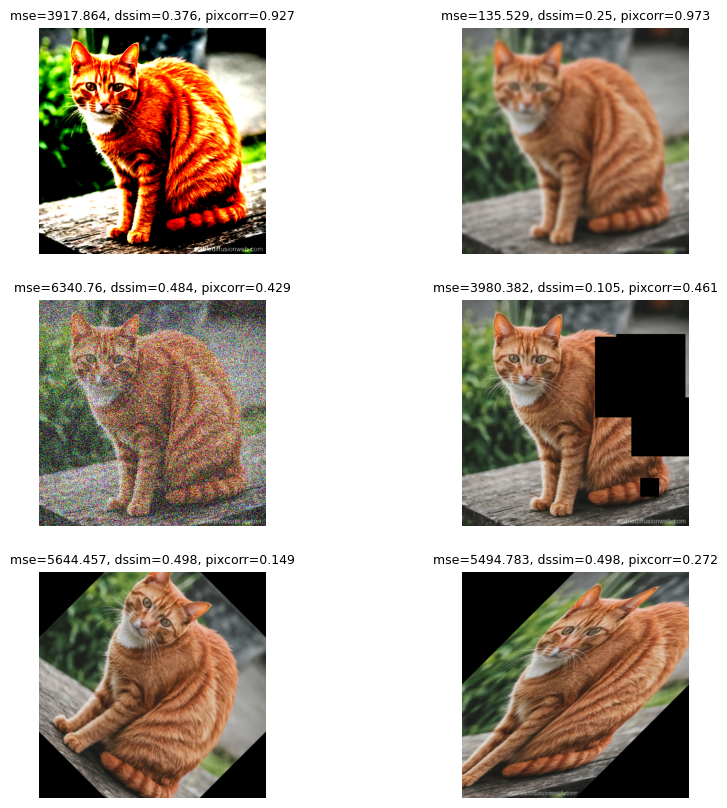

In [495]:
import matplotlib.pyplot as plt

n = int(len(augmented_imgs) / 2)
_, axs = plt.subplots(n, 2, figsize=(10, 10))
axs = axs.flatten()
for img, mse_loss, dssim_loss, pixcorr, ax in zip(augmented_imgs, mse_losses, dssim_losses, pixcorrs, axs):
    ax.imshow(img)
    ax.set_title(f"mse={round(mse_loss.item(), 3)}, dssim={round(dssim_loss.item(), 3)}, pixcorr={round(pixcorr.item(), 3)}", fontsize=9)
    ax.set_axis_off()

plt.show()

[Working with Structural Similarity Index. Medium](https://jack-roubaud.medium.com/working-with-structural-similarity-index-86ace619f408)

#### Pre-information: Self-supervised learning. Contrastive learning & Contrastive loss

<div style=display: flex; justify-content: center;>
    <img src='./imgs/ssl.png' style=width:850px>
    <img src='./imgs/ssl&cl.jpg' style=width:460px>
</div>    

<div style="text-align: center;">
    <img src='./imgs/constrastive_learning.jpg' style=width:900px>
    <img src='./imgs/deep_learning.jpg' style=width:900px>
</div>

1. Contrastive loss
<div style="display: flex; justify-content: center; align-items: center;">
    <img src='./imgs/positive_pair.png' style="width:310px;">
    <img src='./imgs/negative_pair.png' style="width:265px;">
</div>

$$L = (1 - y) \cdot D^2 + y \cdot max(0, m - D)^2$$
* $y \in \{0, 1\} $
* D - Euclide distance
* m - margin

2. Triplet loss
<div style="display: flex; justify-content: center; align-items: center;">
    <img src='./imgs/triplet_loss.png' style="width:500px;">
</div>

$$L = max(0, D(A, P) - D(A, N) + m)$$
* A - anchor, P - positive sample, N - negative sample
* D - Euclide distance
* m - margin

3. InfoNCE loss

<div style="display: flex; justify-content: center; align-items: center;">
    <img src='./imgs/infoNCE_loss.png' style="width:350px;">
</div>

$$L = - log\frac{exp(D_P)}{\sum_i exp(D_{K_i})}$$
* $ K = \{N_1, ... N_k, P\}$
* D - Euclide distance

[Contrastive Learning with SimCLR | Deep Learning Animated. Youtube](https://www.youtube.com/watch?v=UqJauYELn6c&t=642s&ab_channel=Deepia)\
[Data Learning: Towards Better Understanding of Contrastive Learning.Youtube](https://www.youtube.com/watch?v=1oYRBUXb0NU&list=PLhlnCXGrJEEGjP1ALCszJtjB9Mg-L3ZXd&index=1&ab_channel=DataLearning%40ICL)

#### 5.3 Contrastive Language-Image Pre-Training

<div style=display: flex; justify-content: center;>
    <img src='./imgs/clip.png' style=width:960px>
    <img src='./imgs/clip_loss.png' style=width:390px>
</div>

[Radford A. Learning Transferable Visual Models From Natural Language Supervision. 2021](https://arxiv.org/pdf/2103.00020)[[GitHub](https://github.com/OpenAI/CLIP)]

##### Пример: Kandinsky2.2

In [ ]:
import clip
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clip_model, preprocess = clip.load("ViT-L/14", device=device)
model = clip_model.encode_image

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(torch.cat([gen_tensors, orig_tensors]).mean(dim=0).mean(dim=1).mean(1),
                         torch.cat([gen_tensors, orig_tensors]).std(dim=0).std(dim=1).std(1))
])


preds = model(torch.stack([preprocess(recon) for recon in gen_tensors], dim=0).to(device))
reals = model(torch.stack([preprocess(indiv) for indiv in orig_tensors], dim=0).to(device))
preds = preds.float().flatten(1).detach().cpu().numpy()
reals = reals.float().flatten(1).detach().cpu().numpy()

r = np.corrcoef(reals, preds)
r = r[:len(orig_tensors), len(orig_tensors):]
congruents = np.diag(r)

print(np.mean(congruents))

0.8048160194075132


In [47]:
congruents

array([0.81623734, 0.82266267, 0.7716744 , 0.77349299, 0.80460088,
       0.79447189, 0.85057196])

#### 5.4 Swapping Assignments between multiple Views

<div style="text-align: center;">
    <img src='./imgs/swav.png' style=width:800px>
    <img src='./imgs/swav.gif' style=width:800px>
</div>


- These contrastive methods typically work online and rely on a large number of explicit pairwise feature comparisons, which is computationally challenging.
In this paper, we propose an online algorithm, SwAV, that takes advantage of contrastive methods without requiring to compute pairwise comparisons
- Specifically, our method simultaneously clusters the data while enforcing consistency between cluster assignments produced for different augmentations (or “views”) of the same image, instead of comparing features directly as in contrastive learning.
- Our method can be trained with large and small batches and can scale to unlimited amounts of data. Compared to previous contrastive methods, our method is more memory efficient since it does not require a large memory bank or a special momentum network



[Caron M. Unsupervised learning of visual features by contrasting cluster assignments. 2020](https://dl.acm.org/doi/abs/10.5555/3495724.3496555)[[GitHub](https://github.com/facebookresearch/swav)]\
[Sik-Ho Tsang. Review — SwAV: Unsupervised Learning of Visual Features by Contrasting Cluster Assignments. Medium](https://sh-tsang.medium.com/swav-unsupervised-learning-of-visual-features-by-contrasting-cluster-assignments-f36dc9a7affc)

##### Пример: Kandinsky2.2

In [ ]:
import scipy as sp
from torchvision.models.feature_extraction import create_feature_extractor

swav_model = torch.hub.load('facebookresearch/swav:main', 'resnet50')
swav_model = create_feature_extractor(swav_model, 
                                      return_nodes=['avgpool']).to(device)
swav_model.eval().requires_grad_(False)

preprocess = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Normalize(torch.cat([gen_tensors, orig_tensors]).mean(dim=0).mean(dim=1).mean(1),
                         torch.cat([gen_tensors, orig_tensors]).std(dim=0).std(dim=1).std(1))
])

gt = swav_model(preprocess(orig_tensors.to(device)))['avgpool']
gt = gt.reshape(len(gt),-1).cpu().numpy()
fake = swav_model(preprocess(gen_tensors.to(device)))['avgpool']
fake = fake.reshape(len(fake),-1).cpu().numpy()

swav = np.array([sp.spatial.distance.correlation(gt[i],fake[i]) for i in range(len(gt))]).mean()
print("Distance:", swav)

Using cache found in C:\Users\kshch/.cache\torch\hub\facebookresearch_swav_main
c:\Users\kshch\Projects\2024_processing_and_generating_images_course\lesson materials\metrics_of_generation_task\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kshch\Projects\2024_processing_and_generating_images_course\lesson materials\metrics_of_generation_task\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Distance: 0.0679274894988673


In [ ]:
!pip freeze > requirements.txt

Еще метрики сравнения изображений:
- Mean Squared Error (MSE) & Root Mean Squared Error (RMSE)
- Peak Signal-to-Noise Ratio (PSNR)
- Erreur Relative Globale Adimensionnelle de Synthèse (ERGAS)
- Spatial Correlation Coefficient (SCC)
- Relative Average Spectral Error (RASE)
- Spectral Angle Mapper (SAM)
- Visual Information Fidelity (VIF)